Hello this is the example notebook for WebNET in colab as of 10/22/2025
This notebook highlights the early experiments of this project. We'll connect our collab to ngrok a broker who will handle the transfering of data to webgpu and back to colab. web gpu makes use of your local machine.

I truly believe decetralized compute and at least inferance is a necessity for the future. This is hopefully a step in that direction.

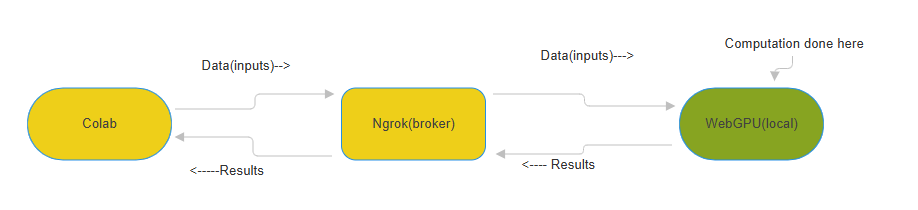

In [1]:
#Clone Repository & Change Directory
# This makes the notebook self-contained and reproducible.
!git clone https://github.com/LoganCarlisle/WebNET.git
%cd WebNET

Cloning into 'WebNET'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 29 (delta 6), reused 25 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (29/29), 1.38 MiB | 7.31 MiB/s, done.
Resolving deltas: 100% (6/6), done.
/content/WebNET


In [2]:
#Install Dependencies & Configure ngrok
!pip install "fastapi[all]" pyngrok qrcode[pil] requests numpy --quiet
from google.colab import userdata

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.7/517.7 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.8/456.8 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 951.9/951.9 kB 47.8 MB/s eta 0:00:00


Step-by-Step Guide 🔑
Here is a simple, step-by-step guide to get a ngrok key

Sign in to your ngrok account at https://dashboard.ngrok.com/login. If you don't have an account, you can sign up for a free one.

Once you're logged in, look at the sidebar on the left-hand side of the page. Click on the section labeled "Your Authtoken".

Your personal authtoken will be displayed on this page. You can click the "Copy" button to copy it to your clipboard.

Then back in colab toggle Secrets and add your key

!make sure to not accidently leak your key(im lowkey afraid of that happening to me)

In [3]:
# Get the user's ngrok key from Colab's secret manager for security
NGROK_AUTHTOKEN = userdata.get('ngrok_Key')


In [4]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 21.8 MB/s eta 0:00:00


 Broker is up!
 Click here to launch the Web Worker: https://391168feb306.ngrok-free.app

📱 For Mobile Worker (Future App): Scan the QR code below.


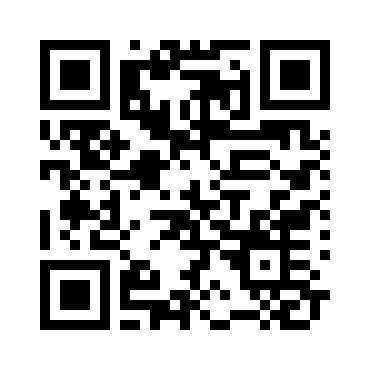

In [5]:
import sys
import numpy as np

# Add the 'client_notebooks' directory to Python's path so it can find our library
sys.path.append('client_notebooks')
from metal_forge_lib import MetalForgeSession

# Initialize and start our compute session. This will display a QR code that doesnt work.
session = MetalForgeSession(ngrok_authtoken=NGROK_AUTHTOKEN)
session.start()

Note for the job to be sent(the next cell) the ngrok link has to be opened qr code is not be functional as of 10/22/25

Now that you have your WebGPU worker ready we run the proof of concept.
We'll define a simple model in torch convert it to onnx and then send it over to our WebGPU worker.


In [6]:
import torch.nn as nn
import torch
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.linear1 = nn.Linear(40, 8196)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(8196, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.linear2(self.relu(self.linear1(x))))

my_model = SimpleModel()
my_model.eval() # Set the model to eval

# Create a dummy input tensor with the correct shape.
# run it through ONNX as it needs this to trace the model's structure and figure out how it works.
dummy_input = torch.randn(1, 40) # (batch size of 1, 4 features)

# Load the model onto the connected worker.
session.load_onnx_model_on_worker(my_model, dummy_input)

Converting PyTorch model to ONNX format
Sending ONNX model to worker
Sending job 1 to worker: {'job_id': '1', 'data': {'operation': 'load_onnx_model', 'onnx_model_b64': 'CAgSB3B5dG9yY2gaBTIuOC4wOuyJVAqJAQoMb25ueDo6R2VtbV8wCg5saW5lYXIxLndlaWdodAoMbGlu...(1836724 bytes)...uDtaHgoMb25ueDo6R2VtbV8wEg4KDAgBEggKAggBCgIIKGITCgE4Eg4KDAgBEggKAggBCgIIAUICEBI='}}
Job 1 queued; waiting for result...
Job 1 submitted to worker...
 ONNX Model sent. The worker is now ready for inference.


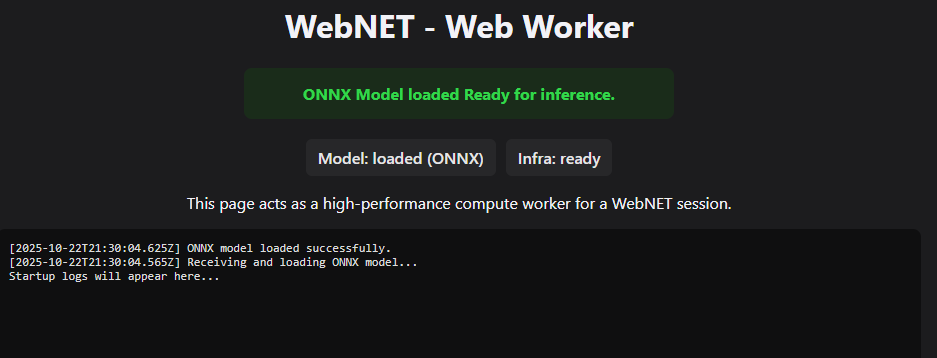

Forgive me for this terrible webpage🙏
I might just go all in on the cli look but once scaling up of devices happens I still want to keep it clean and intuitive.

In [7]:
print("\n lets see if this works fr")

# Create some sample data with the same shape as the dummy input
sample_data = np.random.rand(1, 40).astype(np.float32)

# This command sends the data to the worker and waits for the prediction
result = session.run(
    operation="onnx_inference",
    data={"input_data": sample_data.tolist()}
)

if result:
    print("\n--- INFERENCE COMPLETE ---")
    print("Input Data:", sample_data)
    print("Prediction (from ONNX.js worker):", np.array(result))


 lets see if this works fr
Sending job 2 to worker: {'job_id': '2', 'data': {'operation': 'onnx_inference', 'input_data': [[0.8892675042152405, 0.20531818270683289, 0.6163854002952576, 0.8988936543464661, 0.1493362933397293, 0.5397409796714783, 0.900833785533905, 0.12524284422397614, 0.7675507664680481, 0.11824202537536621, 0.3793671429157257, 0.451434463262558, 0.0990421250462532, 0.8886914849281311, 0.06965786963701248, 0.6517377495765686, 0.16634491086006165, 0.1851215660572052, 0.5193871855735779, 0.006684874650090933, 0.7387587428092957, 0.8939516544342041, 0.3802906274795532, 0.5241302847862244, 0.4296835660934448, 0.9650987386703491, 0.18643653392791748, 0.43302345275878906, 0.1409967690706253, 0.21467961370944977, 0.884750485420227, 0.20516350865364075, 0.18908533453941345, 0.029565762728452682, 0.37077027559280396, 0.4788898825645447, 0.8250834941864014, 0.6360011100769043, 0.558069109916687, 0.37624070048332214]]}}
Job 2 queued; waiting for result...
Job 2 submitted to worke

Tada! It worked!

Also Ngrok is prett sensitive if you have a task open already so if so go in task mangager and kill the ngrok task if its causing issues.

In [8]:
# Shut down the server and the ngrok session
session.close()

Tunnel closed.


Next steps is forming federated clusters safely. And most importantly hooking up newer gen iphones to colab to make use of there compute, thats where I think there is the greatest amount of hope for pooling massive amounts of computing power together. Unfortunantly I dont have a mac to work on metal and the ios side, if somebody out there is willing to help I would be greatly apprecietive. Im only worried about Apple app rule, hopefully apple is chill about distributed compute and stuff. Also I might have to change the name of the respostiory metal-forge sounds limiting?